<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practice/Practicing_on_Sarcasm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the Sarcasm Dataset**

In [1]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-10-19 17:16:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-10-19 17:16:58 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

with open("/tmp/sarcasm.json") as f:
    datastore = json.load(f)

# **2. Data Preprocessing**

In [3]:
headlines = []
urls = []
labels = []

for item in datastore:
    headlines.append(item["headline"])
    urls.append(item["article_link"])
    labels.append(item["is_sarcastic"])


print("Size of dataset: {}".format(len(headlines)))

Size of dataset: 26709


In [4]:
headlines[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [5]:
labels[:5]

[0, 0, 1, 1, 0]

In [6]:
oov_token = "<OOV>"
training_size = 20000
max_len = 100
vocab_size = 10000
embedding_dim = 16
trunc_type = "post"
pad_type = "post"

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(headlines)

sequences = tokenizer.texts_to_sequences(headlines)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding=pad_type, 
                                 truncating=trunc_type)

print("Headline : {}".format(headlines[0]))
print("Tokenized Sequence : {}".format(sequences[0]))
print("Padded Sequence : {}".format(padded_sequences[0]))

Headline : former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized Sequence : [308, 1, 679, 3337, 2298, 48, 382, 2576, 1, 6, 2577, 8434]
Padded Sequence : [ 308    1  679 3337 2298   48  382 2576    1    6 2577 8434    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [8]:
train_padded = np.array(padded_sequences[:training_size])
valid_padded = np.array(padded_sequences[training_size:])

train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

print(len(train_padded))
print(len(valid_padded))

20000
6709


# **Model with Dense Layers**

In [9]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 0.6232 - accuracy: 0.6442 - val_loss: 0.4485 - val_accuracy: 0.8147
Epoch 2/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3469 - accuracy: 0.8564 - val_loss: 0.3712 - val_accuracy: 0.8338
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.2644 - accuracy: 0.8934 - val_loss: 0.3407 - val_accuracy: 0.8554
Epoch 4/20
625/625 [==============================] - 3s 4ms/step - loss: 0.2190 - accuracy: 0.9143 - val_loss: 0.3684 - val_accuracy: 0.8457
Epoch 5/20
625/625 [==============================] - 3s 4ms/step - loss: 0.1854 - accuracy: 0.9291 - val_loss: 0.3639 - val_accuracy: 0.8554
Epoch 6/20
625/625 [==============================] - 3s 4ms/step - loss: 0.1593 - accuracy: 0.9403 - val_loss: 0.3907 - val_accuracy: 0.8542
Epoch 7/20
625/625 [==============================] - 3s 4ms/step - loss: 0.1397 - accuracy: 0.9484 - val_loss: 0.4134 - val_accuracy: 0.8529
Epoch 

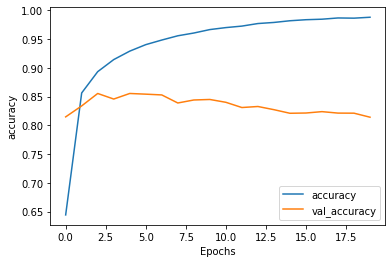

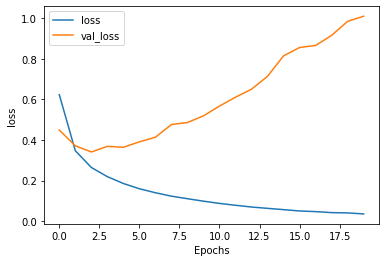

In [11]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.legend([string, "val_" + string])
    plt.show()


plot_graph(history, "accuracy")
plot_graph(history, "loss")

# **Model with Single RNN Layer**

In [13]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.SimpleRNN(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 32s 51ms/step - loss: 0.6977 - accuracy: 0.5303 - val_loss: 0.6956 - val_accuracy: 0.5403
Epoch 2/20
625/625 [==============================] - 32s 51ms/step - loss: 0.6882 - accuracy: 0.5598 - val_loss: 0.6711 - val_accuracy: 0.6092
Epoch 3/20
625/625 [==============================] - 31s 50ms/step - loss: 0.6696 - accuracy: 0.6098 - val_loss: 0.6723 - val_accuracy: 0.6013
Epoch 4/20
625/625 [==============================] - 31s 49ms/step - loss: 0.6702 - accuracy: 0.6039 - val_loss: 0.6718 - val_accuracy: 0.5938
Epoch 5/20
625/625 [==============================] - 31s 49ms/step - loss: 0.6703 - accuracy: 0.5927 - val_loss: 0.6742 - val_accuracy: 0.5633
Epoch 6/20
625/625 [==============================] - 31s 50ms/step - loss: 0.6696 - accuracy: 0.5885 - val_loss: 0.6715 - val_accuracy: 0.5831
Epoch 7/20
625/625 [==============================] - 31s 49ms/step - loss: 0.6703 - accuracy: 0.5842 - val_loss: 0.6708 - val_accuracy:

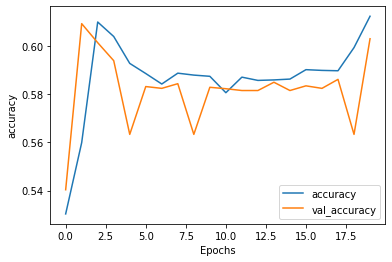

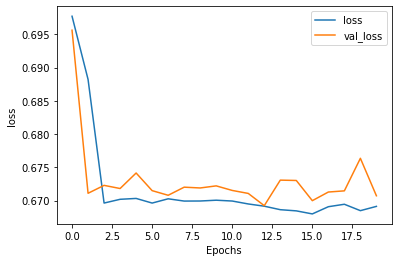

In [14]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

# **Model with Multiple RNN Layers**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.SimpleRNN(128, return_sequences=True),
    keras.layers.SimpleRNN(128)
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

In [ ]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

# **Model with Single LSTM Layer**

In [17]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.LSTM(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 6s 10ms/step - loss: 0.6865 - accuracy: 0.5603 - val_loss: 0.6856 - val_accuracy: 0.5633
Epoch 2/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6862 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 4/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 5/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 6/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 7/20
625/625 [==============================] - 6s 9ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch

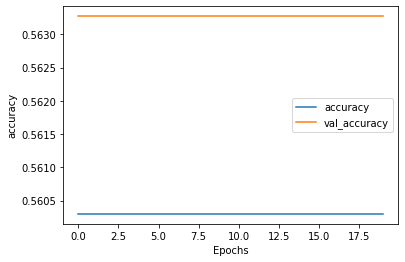

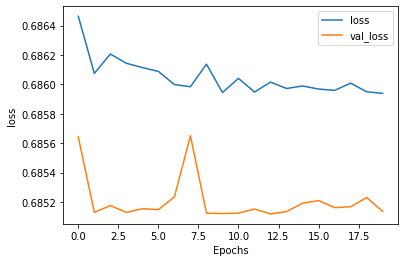

In [18]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

# **Model with Multiple LSTM Layers**

In [20]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 10s 15ms/step - loss: 0.6864 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 2/20
625/625 [==============================] - 9s 15ms/step - loss: 0.6856 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 3/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.563

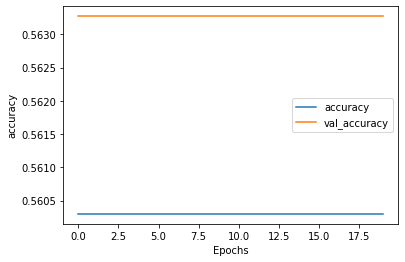

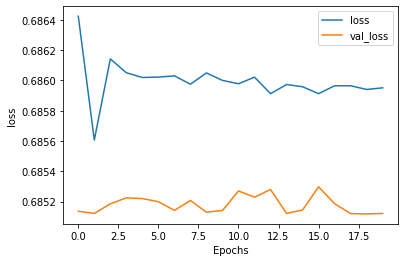

In [21]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

# **Model with Multiple GRU Layers**

In [22]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6864 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6863 - accuracy: 0.5603 - val_loss: 0.6853 - val_accuracy: 0.5633
Epoch 3/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 4/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633
Epoch 5/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6854 - val_accuracy: 0.5633
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6851 - val_accuracy: 0.5633
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 0.6861 - accuracy: 0.5603 - val_loss: 0.6852 - val_accuracy: 0.5633

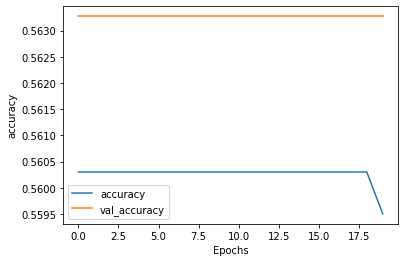

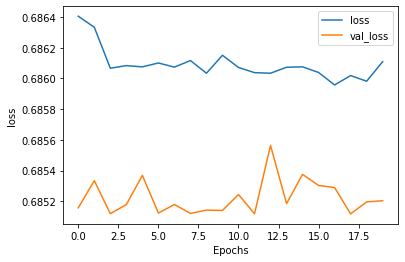

In [23]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")